# Hypothesis 2: Attitudinal Moderation
## AI Attitudes Moderate SDT → AI Acceptance Relationship

**Hypothesis**: The positive relationship between TENS_Life_mean and UTAUT_AI_mean will be stronger among individuals with higher general AI positivity (GAAIS_mean).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from data_utils import load_and_prepare_data
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Load data
try:
    combined_data = pd.read_csv('data/processed/combined_data.csv')
    print("✓ Loaded processed data")
except FileNotFoundError:
    combined_data = load_and_prepare_data()
    combined_data.to_csv('data/processed/combined_data.csv', index=False)
    print("✓ Data loaded and saved")


✓ Loaded processed data


In [3]:
# Prepare data
h2_data = combined_data[['TENS_Life_mean', 'UTAUT_AI_mean', 'GAAIS_mean', 
                          'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']].dropna()

if h2_data['gender'].dtype == 'object':
    h2_data['gender'] = pd.Categorical(h2_data['gender']).codes

# Center variables
h2_data['TENS_Life_centered'] = h2_data['TENS_Life_mean'] - h2_data['TENS_Life_mean'].mean()
h2_data['GAAIS_centered'] = h2_data['GAAIS_mean'] - h2_data['GAAIS_mean'].mean()
h2_data['TENS_x_GAAIS'] = h2_data['TENS_Life_centered'] * h2_data['GAAIS_centered']

print(f"Sample size: {len(h2_data)}")


Sample size: 2085


In [4]:
# Moderated regression
X_h2 = h2_data[['TENS_Life_centered', 'GAAIS_centered', 'TENS_x_GAAIS', 
                'age', 'gender', 'SSRPH_mean', 'PHQ5_mean']]
X_h2 = sm.add_constant(X_h2)
y_h2 = h2_data['UTAUT_AI_mean']

model_h2 = sm.OLS(y_h2, X_h2).fit()
print("H2 - Moderated Regression:")
print(model_h2.summary())

interaction_coef = model_h2.params['TENS_x_GAAIS']
interaction_p = model_h2.pvalues['TENS_x_GAAIS']
print(f"\nInteraction: β = {interaction_coef:.3f}, p = {interaction_p:.4f}")
print(f"{'✓ H2 SUPPORTED' if interaction_p < 0.05 else '✗ H2 NOT SUPPORTED'}")


H2 - Moderated Regression:
                            OLS Regression Results                            
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     101.0
Date:                Wed, 05 Nov 2025   Prob (F-statistic):          2.75e-127
Time:                        23:00:31   Log-Likelihood:                -1212.3
No. Observations:                2085   AIC:                             2441.
Df Residuals:                    2077   BIC:                             2486.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const    

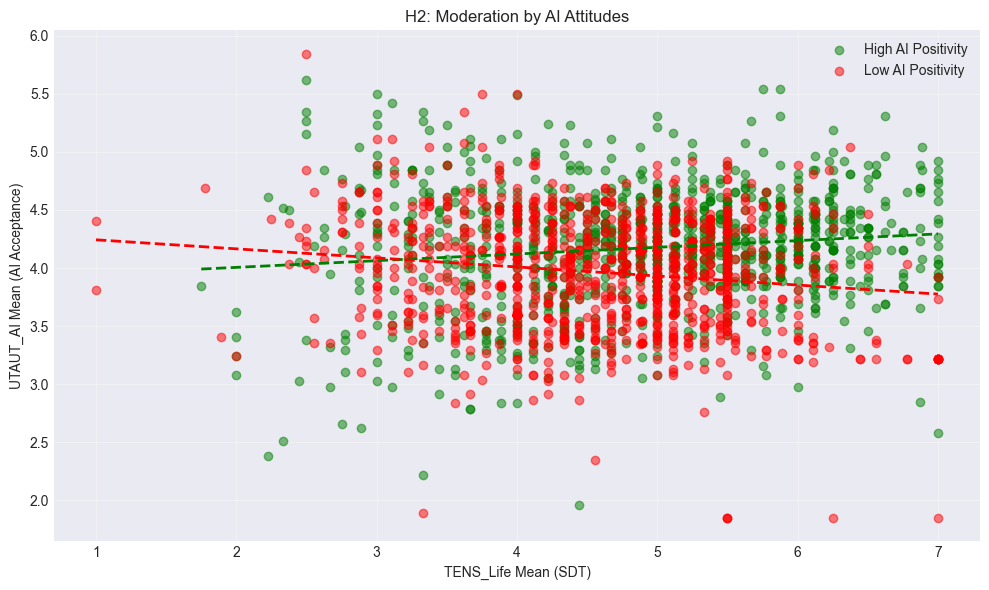

In [6]:
# Visualize interaction
fig, ax = plt.subplots(figsize=(10, 6))

median_gaais = h2_data['GAAIS_mean'].median()
high_gaais = h2_data[h2_data['GAAIS_mean'] >= median_gaais]
low_gaais = h2_data[h2_data['GAAIS_mean'] < median_gaais]

for group, color, label in [(high_gaais, 'green', 'High AI Positivity'), 
                            (low_gaais, 'red', 'Low AI Positivity')]:
    z = np.polyfit(group['TENS_Life_mean'], group['UTAUT_AI_mean'], 1)
    p = np.poly1d(z)
    ax.scatter(group['TENS_Life_mean'], group['UTAUT_AI_mean'], 
               alpha=0.5, label=label, color=color)
    sorted_x = group['TENS_Life_mean'].sort_values()
    ax.plot(sorted_x, p(sorted_x), color=color, linestyle='--', linewidth=2)

ax.set_xlabel('TENS_Life Mean (SDT)')
ax.set_ylabel('UTAUT_AI Mean (AI Acceptance)')
ax.set_title('H2: Moderation by AI Attitudes')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
